In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['figure.dpi'] = 120

In [2]:
df = pd.read_csv('stats_partner_broker.csv')

In [3]:
sys = df[df['topic'].str.startswith('$SYS')]
df = df[df['topic'].str.startswith('$SYS') == False]

In [4]:
df['topic'] = df['topic'].str.replace('counter1', 'counter')

In [5]:
df.head()

ts          topic  qos payload
44  2.436267  counter/2/500    2       0
45  3.003892  counter/2/500    2       1
46  3.417312  counter/2/500    2       2
47  3.927627  counter/2/500    2       3
48  4.535092  counter/2/500    2       4

In [6]:
df.groupby('topic').first()

ts  qos payload
topic                                  
counter/0/0    2068.088817    0       0
counter/0/10   1946.753488    0       0
counter/0/100  1582.041954    0       0
counter/0/20   1825.062656    0       0
counter/0/50   1703.585170    0       0
counter/0/500  1460.515289    0       0
counter/1/0    1338.988410    1       0
counter/1/10   1217.473347    1       0
counter/1/100   852.963900    1       0
counter/1/20   1095.951502    1       0
counter/1/50    974.486243    1       0
counter/1/500   731.463782    1       0
counter/2/0     609.990249    2       0
counter/2/10    488.444762    2       0
counter/2/100   123.928140    2       0
counter/2/20    367.007009    2       0
counter/2/50    245.468195    2       0
counter/2/500     2.436267    2       0

In [8]:
data = df.groupby('topic').describe()[['ts']]
data = data['ts']
data['max'] - data['min']

topic
counter/0/0      119.908022
counter/0/10     119.734300
counter/0/100    119.849182
counter/0/20     119.920277
counter/0/50     119.858312
counter/0/500    119.620458
counter/1/0      120.156028
counter/1/10     120.104531
counter/1/100    119.924891
counter/1/20     119.946446
counter/1/50     119.911979
counter/1/500    119.929062
counter/2/0      120.024675
counter/2/10     120.209595
counter/2/100    119.871198
counter/2/20     119.997819
counter/2/50     119.906742
counter/2/500    119.454436
dtype: float64

In [9]:
df['topic'].value_counts().sort_index()

counter/0/0      18797
counter/0/10      7680
counter/0/100     1097
counter/0/20      3840
counter/0/50      1920
counter/0/500      236
counter/1/0       7452
counter/1/10      7674
counter/1/100     1097
counter/1/20      3840
counter/1/50      1921
counter/1/500      237
counter/2/0       6270
counter/2/10      5549
counter/2/100     1097
counter/2/20      3838
counter/2/50      1921
counter/2/500      236
Name: topic, dtype: int64

In [10]:
df['qos'] = df['qos'].astype(int)
df['payload'] = df['payload'].astype(int)

The overall average rate of messages you actually receive across the period [messages/second].

In [11]:
data = df.groupby('topic').count()[['ts']] / (df.groupby('topic').last()[['ts']] - df.groupby('topic').first()[['ts']])
data.reset_index(inplace=True)
data = pd.concat([data, data['topic'].str.split('/', expand=True)], axis=1)
data.rename(columns={1:'qos', 2:'delay'}, inplace=True)
data.drop(0, 1, inplace=True)
data.sort_values(['delay', 'qos'], inplace=True)

In [12]:
topics = list(df['topic'].unique())
topics = sorted(topics, key=lambda x: (x.split('/')[-1], x.split('/')[1]))
topics

['counter/0/0',
 'counter/1/0',
 'counter/2/0',
 'counter/0/10',
 'counter/1/10',
 'counter/2/10',
 'counter/0/100',
 'counter/1/100',
 'counter/2/100',
 'counter/0/20',
 'counter/1/20',
 'counter/2/20',
 'counter/0/50',
 'counter/1/50',
 'counter/2/50',
 'counter/0/500',
 'counter/1/500',
 'counter/2/500']

In [13]:
data

topic          ts qos delay
0     counter/0/0  156.761822   0     0
6     counter/1/0   62.019361   1     0
12    counter/2/0   52.239258   2     0
1    counter/0/10   64.142021   0    10
7    counter/1/10   63.894342   1    10
13   counter/2/10   46.161041   2    10
2   counter/0/100    9.153171   0   100
8   counter/1/100    9.147392   1   100
14  counter/2/100    9.151489   2   100
3    counter/0/20   32.021274   0    20
9    counter/1/20   32.014288   1    20
15   counter/2/20   31.983915   2    20
4    counter/0/50   16.018914   0    50
10   counter/1/50   16.020084   1    50
16   counter/2/50   16.020784   2    50
5   counter/0/500    1.972907   0   500
11  counter/1/500    1.976168   1   500
17  counter/2/500    1.975649   2   500

Text(0.5, 1.0, 'Messages received per second')

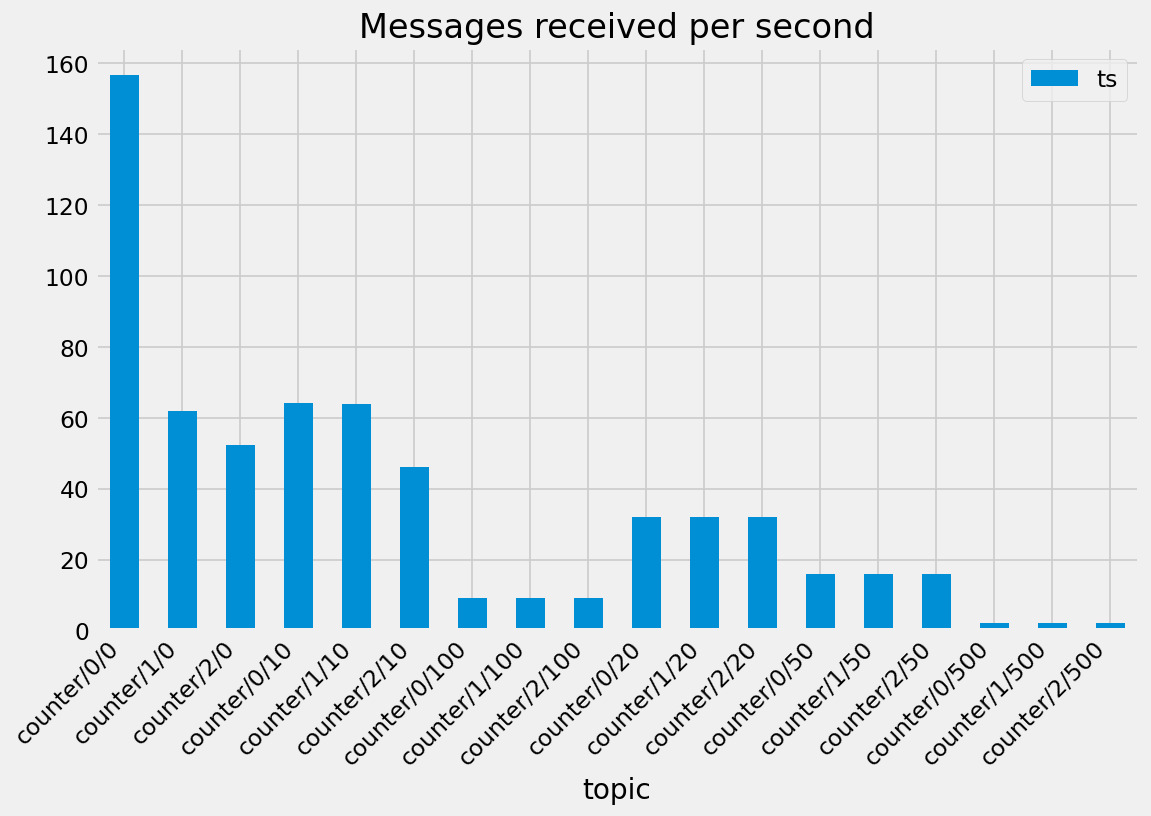

In [14]:
ax = data.set_index('topic').loc[topics].plot(kind='bar', y='ts')
plt.xticks(rotation=45, horizontalalignment="right")
plt.title('Messages received per second')

The rate of message loss you see [percentage]. (i.e. how many messages should you have seen, minus how many you saw)

In [15]:
# (max counter value - min counter value) - unique number of counter values
data1 = ((df.groupby('topic').max()[['payload']] - df.groupby('topic').min()[['payload']]) + 1) - df.groupby('topic').nunique()[['payload']]
data1.columns = ['n_msg_lost']
data1.reset_index(inplace=True)

In [16]:
data2 = ((df.groupby('topic').max()[['payload']] + 1) - df.groupby('topic').nunique()[['payload']]) / (df.groupby('topic').max()[['payload']] + 1)
data2.columns = ['msg_loss_rate']
data2.reset_index(inplace=True)
pd.merge(data1, data2, how='outer')

topic  n_msg_lost  msg_loss_rate
0     counter/0/0           0       0.000000
1    counter/0/10           0       0.000000
2   counter/0/100           0       0.000000
3    counter/0/20           0       0.000000
4    counter/0/50           0       0.000000
5   counter/0/500           0       0.000000
6     counter/1/0      378450       0.980689
7    counter/1/10           0       0.000000
8   counter/1/100           0       0.000000
9    counter/1/20           0       0.000000
10   counter/1/50           0       0.000000
11  counter/1/500           0       0.000000
12    counter/2/0      257657       0.976243
13   counter/2/10        2133       0.277662
14  counter/2/100           0       0.000000
15   counter/2/20           0       0.000000
16   counter/2/50           0       0.000000
17  counter/2/500           0       0.000000

In [17]:
print('Unique counter values received')
print(df[df['topic']=='counter/2/10'][['payload']].nunique())
print('\nMax counter value received')
print(df[df['topic']=='counter/2/10'][['payload']].max())

Unique counter values received
payload    5549
dtype: int64

Max counter value received
payload    7681
dtype: int64


The rate of any out-of-order messages you see [percentage] (i.e. how often do you get a smaller number after a larger number)

In [18]:
data = []
for topic in df['topic'].unique():
    topicdf = df[df['topic'] == topic].copy()
    topicdf['prev_payload'] = topicdf['payload'].shift(1)
    n_out_of_order_msgs = len(topicdf[topicdf['payload'] < topicdf['prev_payload']])
    data += [topic, n_out_of_order_msgs],
    
data = pd.DataFrame(data, columns=['topic', 'n_out_of_order_msgs'])
data = pd.concat([data, data['topic'].str.split('/', expand=True)], axis=1)
data.rename(columns={1:'qos', 2:'delay'}, inplace=True)
data.drop(0, 1, inplace=True)
data.sort_values(['delay', 'qos'], inplace=True)
data = data[['topic', 'qos', 'delay', 'n_out_of_order_msgs']]
data

topic qos delay  n_out_of_order_msgs
17    counter/0/0   0     0                    0
11    counter/1/0   1     0                    0
5     counter/2/0   2     0                    0
16   counter/0/10   0    10                    0
10   counter/1/10   1    10                    0
4    counter/2/10   2    10                    0
13  counter/0/100   0   100                    0
7   counter/1/100   1   100                    0
1   counter/2/100   2   100                    0
15   counter/0/20   0    20                    0
9    counter/1/20   1    20                    0
3    counter/2/20   2    20                    0
14   counter/0/50   0    50                    0
8    counter/1/50   1    50                    0
2    counter/2/50   2    50                    0
12  counter/0/500   0   500                    0
6   counter/1/500   1   500                    0
0   counter/2/500   2   500                    0

In [19]:
data2 = df.groupby('topic', as_index=False).nunique()[['topic','payload']]
data2.columns = ['topic', 'unique_counter_values']
data = pd.merge(data, data2, on='topic', how='outer')
data['out_of_order_pct'] = data['n_out_of_order_msgs'] / data['unique_counter_values']
data

topic qos delay  n_out_of_order_msgs  unique_counter_values  \
0     counter/0/0   0     0                    0                  18797   
1     counter/1/0   1     0                    0                   7452   
2     counter/2/0   2     0                    0                   6270   
3    counter/0/10   0    10                    0                   7680   
4    counter/1/10   1    10                    0                   7674   
5    counter/2/10   2    10                    0                   5549   
6   counter/0/100   0   100                    0                   1097   
7   counter/1/100   1   100                    0                   1097   
8   counter/2/100   2   100                    0                   1097   
9    counter/0/20   0    20                    0                   3840   
10   counter/1/20   1    20                    0                   3840   
11   counter/2/20   2    20                    0                   3838   
12   counter/0/50   0    50                    0                   1920   
13   counter/1/50   1    50                    0                   1921   
14   counter/2/50   2    50                    0                   1921   
15  counter/0/500   0   500                    0                    236   
16  counter/1/500   1   500                    0                    237   
17  counter/2/500   2   500                    0                    236   

    out_of_order_pct  
0                0.0  
1                0.0  
2                0.0  
3                0.0  
4                0.0  
5                0.0  
6                0.0  
7                0.0  
8                0.0  
9                0.0  
10               0.0  
11               0.0  
12               0.0  
13               0.0  
14               0.0  
15               0.0  
16               0.0  
17               0.0

The mean and median inter-message-gap you see [milliseconds].

Only measure for actually consecutive messages, ignore the gap if you lose any messages in between.

In [20]:
tmp = df.copy()
tmp['ts_ms'] = tmp['ts'] * 1000

data = []
for topic in tmp['topic'].unique():
    topicdf = tmp[tmp['topic'] == topic].copy()
    topicdf['time_since_last_msg_ms'] = topicdf['ts_ms'] - topicdf['ts_ms'].shift(1)
    data += topicdf,
    
data = pd.concat(data)
data = data.groupby('topic').describe()[['time_since_last_msg_ms']]
data = data.reindex(index=data.index.to_series().str.rsplit('/').str[-1].astype(int).sort_values().index)
cm = sns.light_palette("green", as_cmap=True)
data.style.background_gradient(cmap=cm, axis=0)

<hr>

Compare with $SYS

In [21]:
data = []
for topic in df['topic'].unique():
    topicdf = df[df['topic'] == topic].copy()
    topicdf['time_since_last_msg'] = topicdf['ts'] - topicdf['ts'].shift(1)
    data += topicdf,
    
data = pd.concat(data)
data

ts          topic  qos  payload  time_since_last_msg
44        2.436267  counter/2/500    2        0                  NaN
45        3.003892  counter/2/500    2        1             0.567625
46        3.417312  counter/2/500    2        2             0.413419
47        3.927627  counter/2/500    2        3             0.510316
48        4.535092  counter/2/500    2        4             0.607464
...            ...            ...  ...      ...                  ...
80337  2187.967616    counter/0/0    0    18792             0.000232
80338  2187.974169    counter/0/0    0    18793             0.006553
80339  2187.979699    counter/0/0    0    18794             0.005530
80340  2187.996533    counter/0/0    0    18795             0.016834
80341  2187.996839    counter/0/0    0    18796             0.000306

[74702 rows x 5 columns]

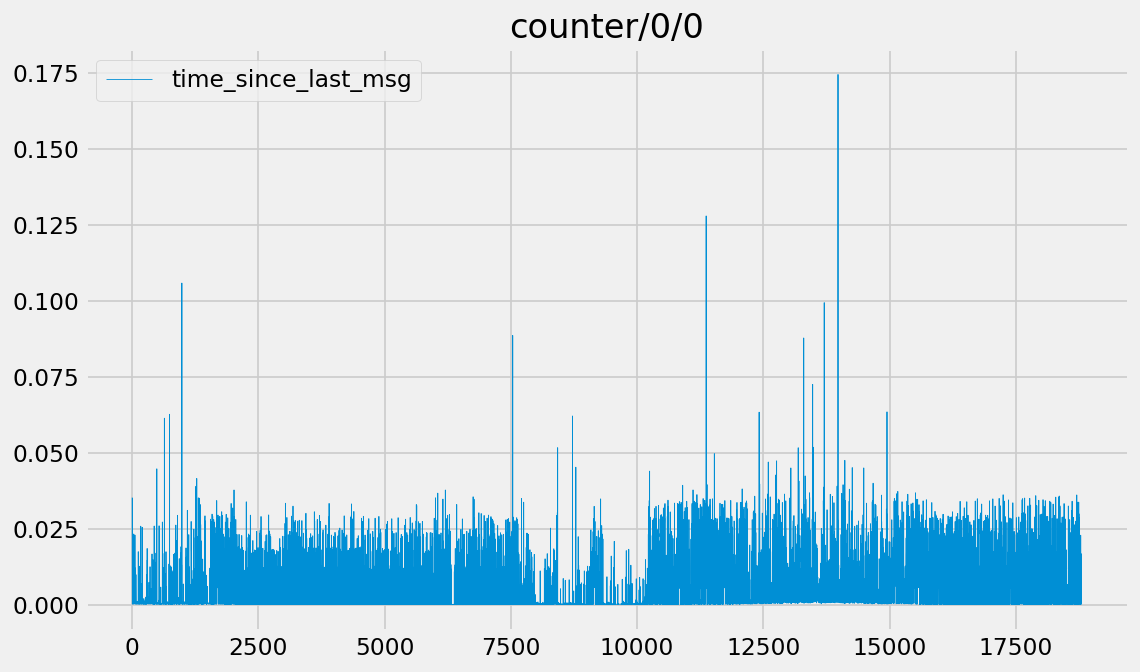

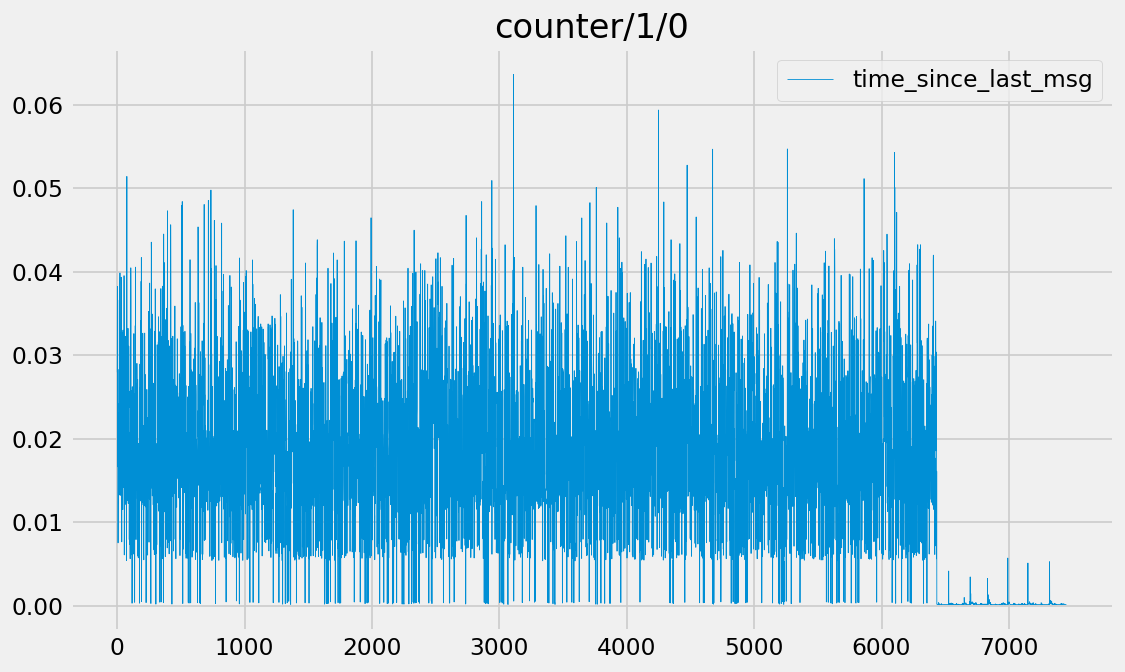

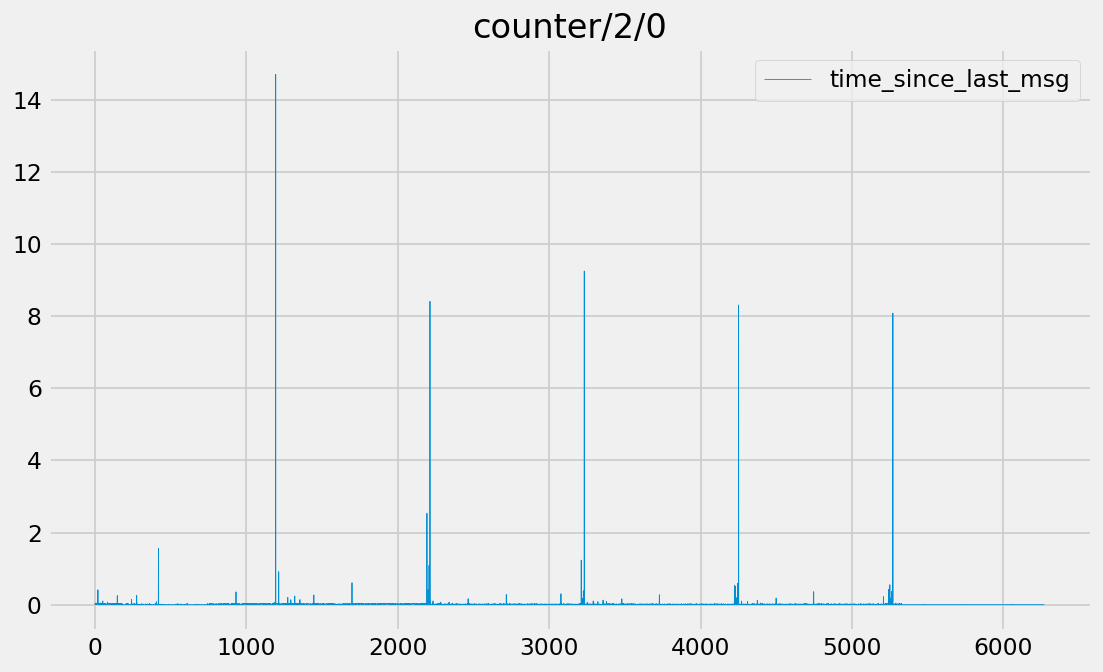

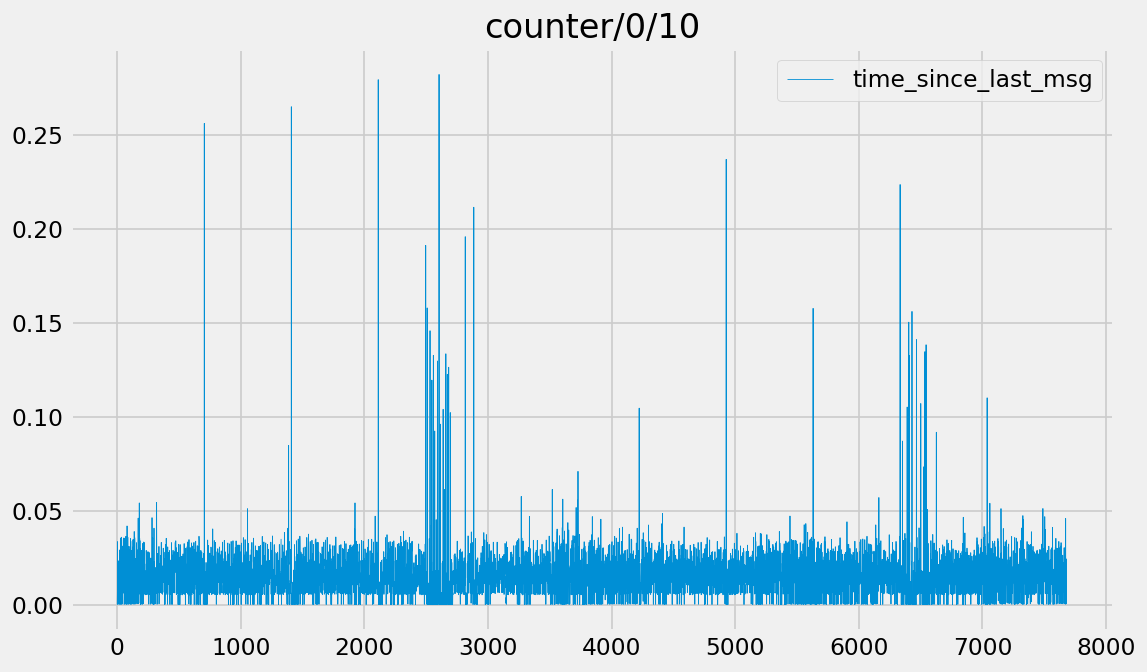

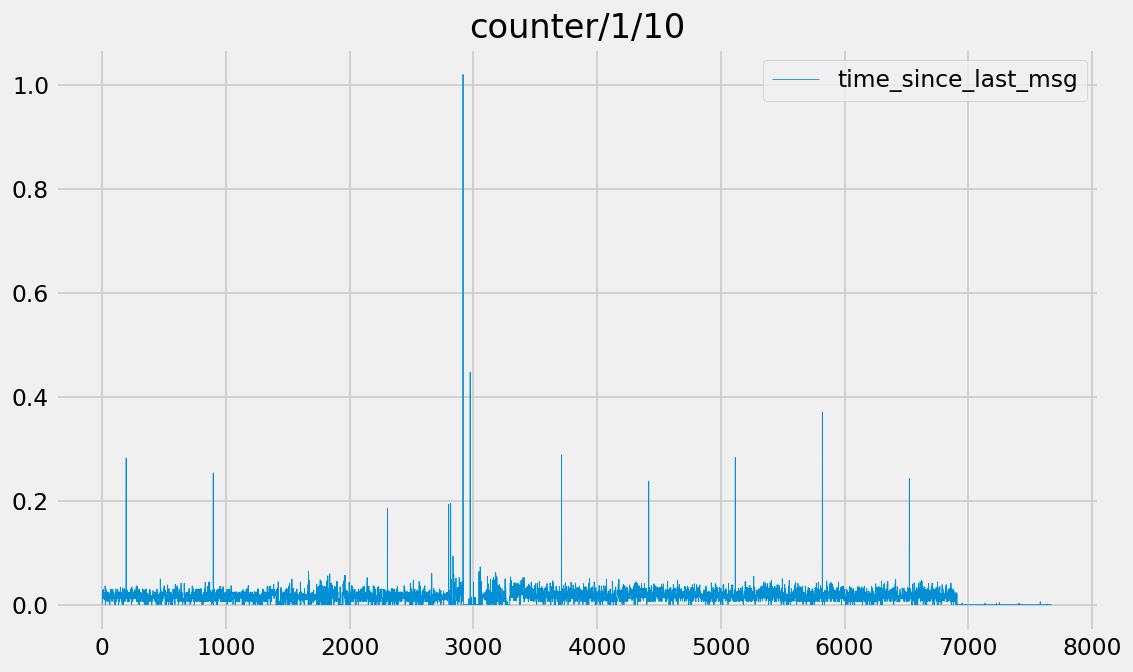

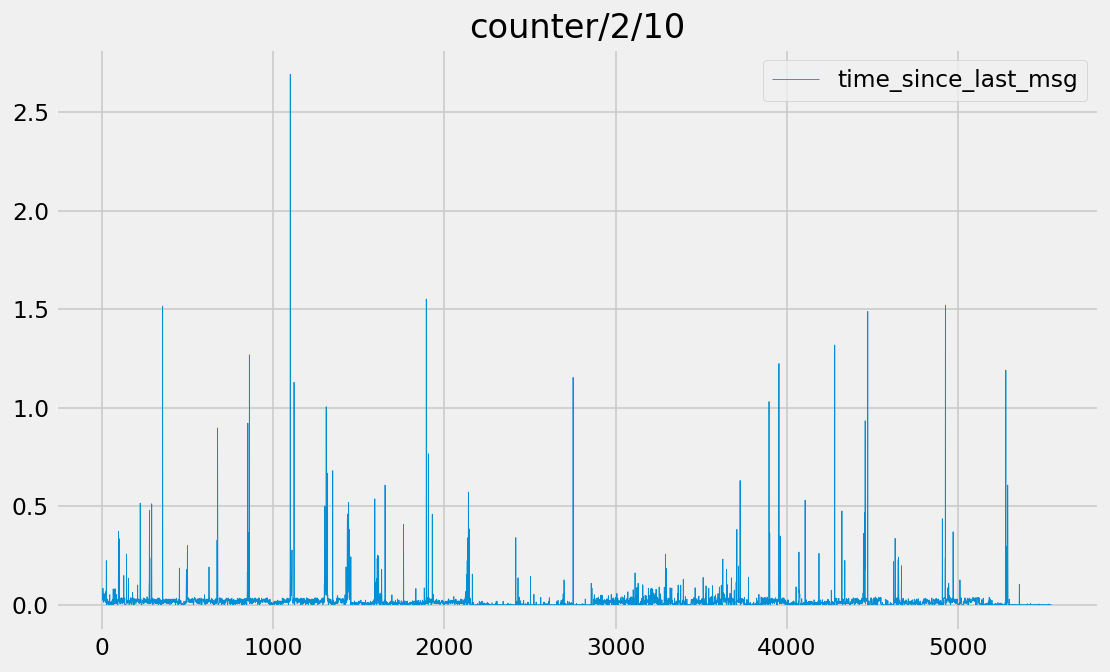

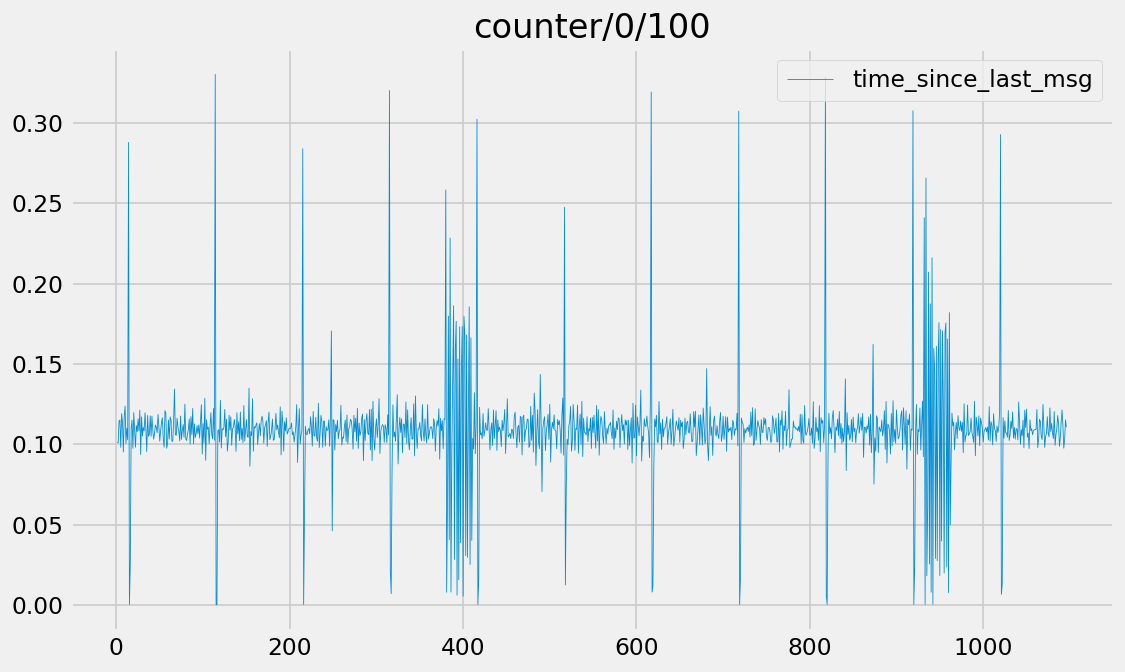

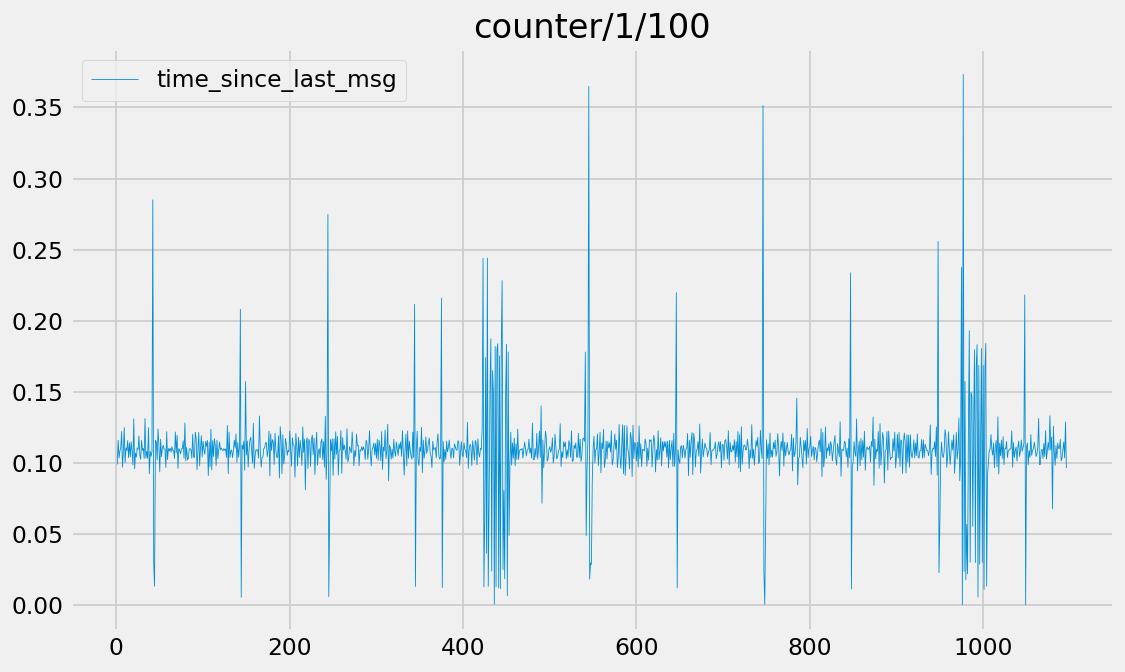

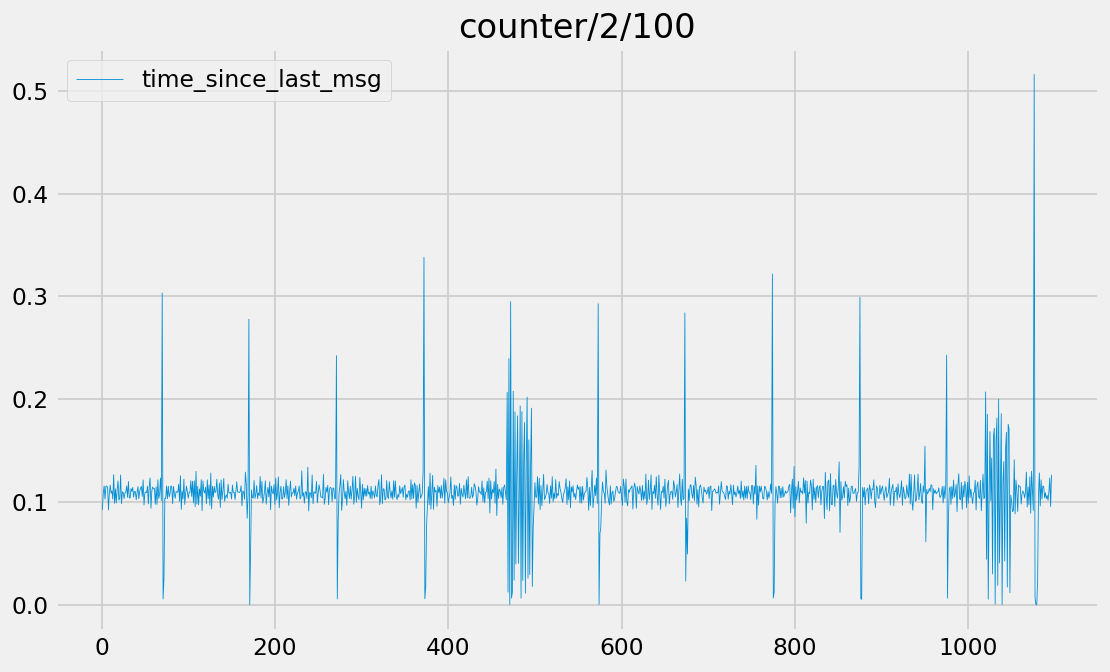

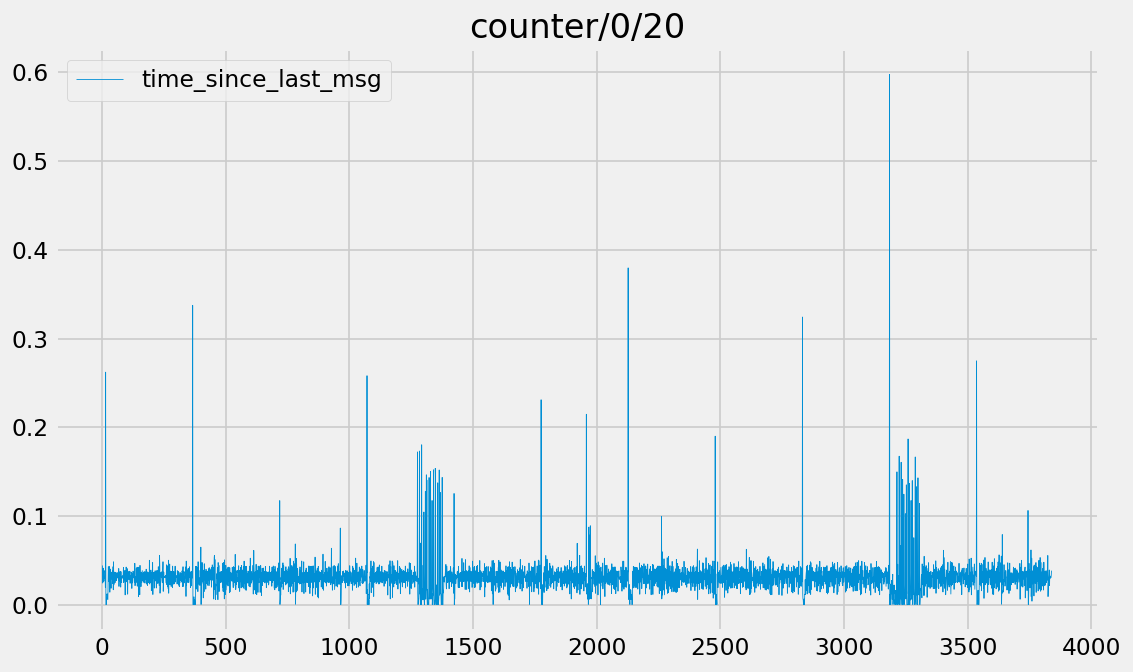

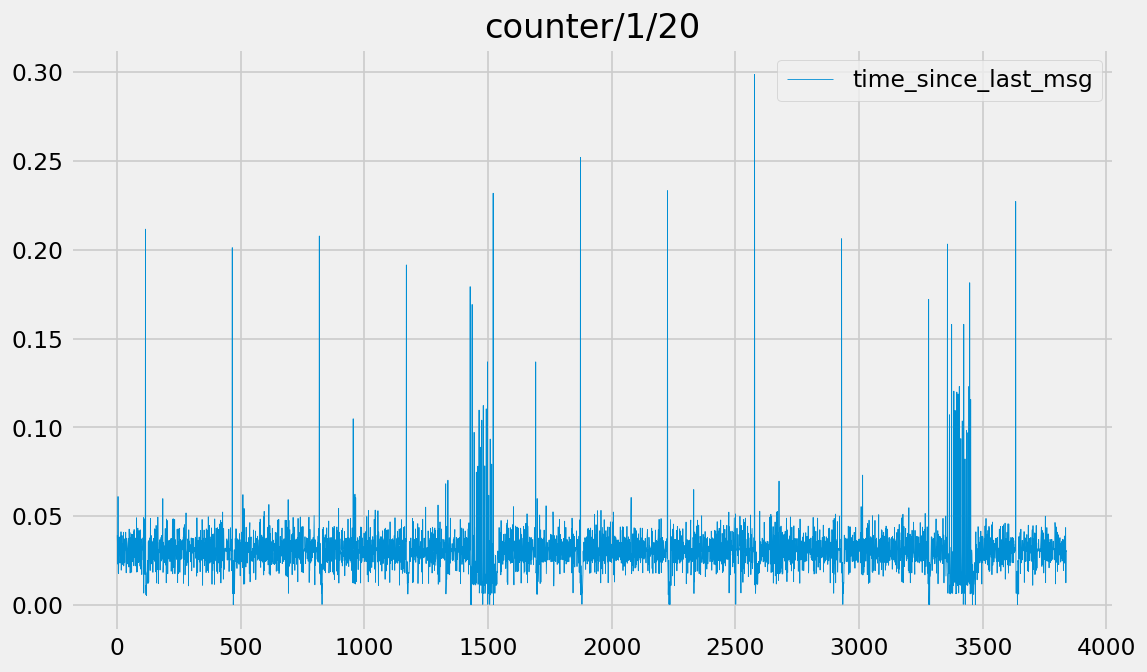

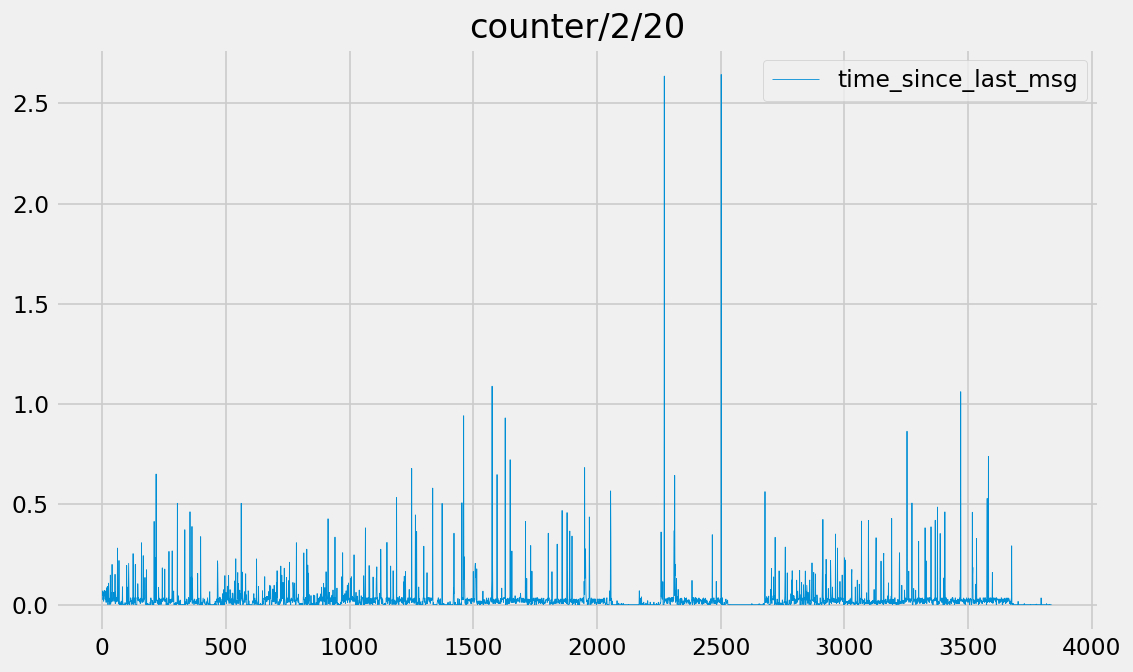

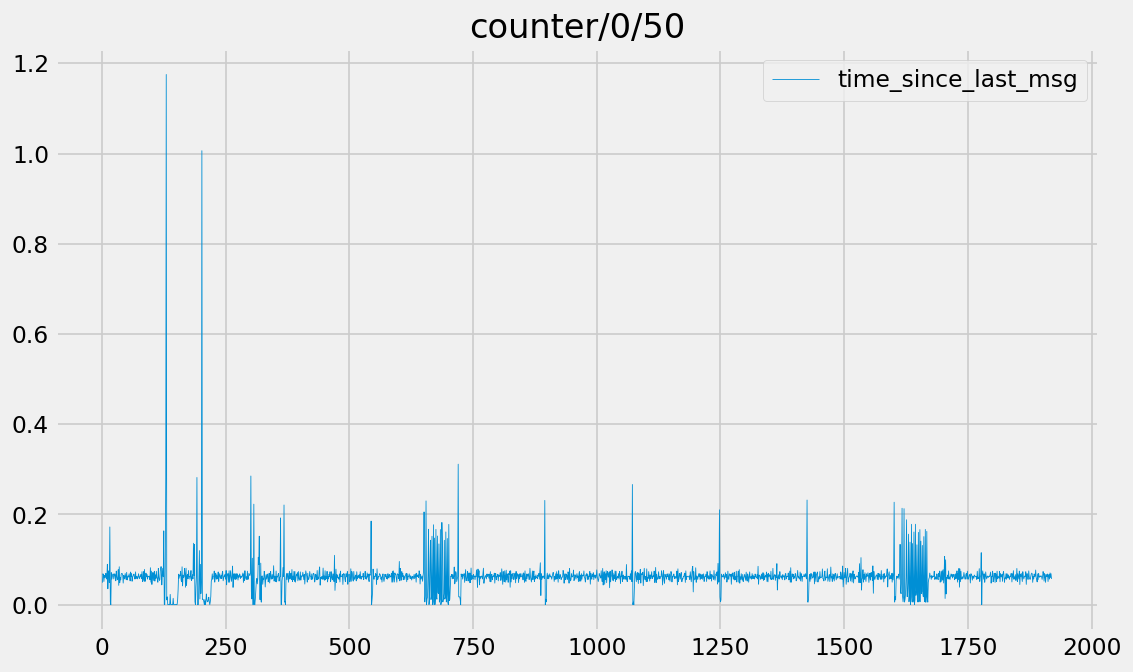

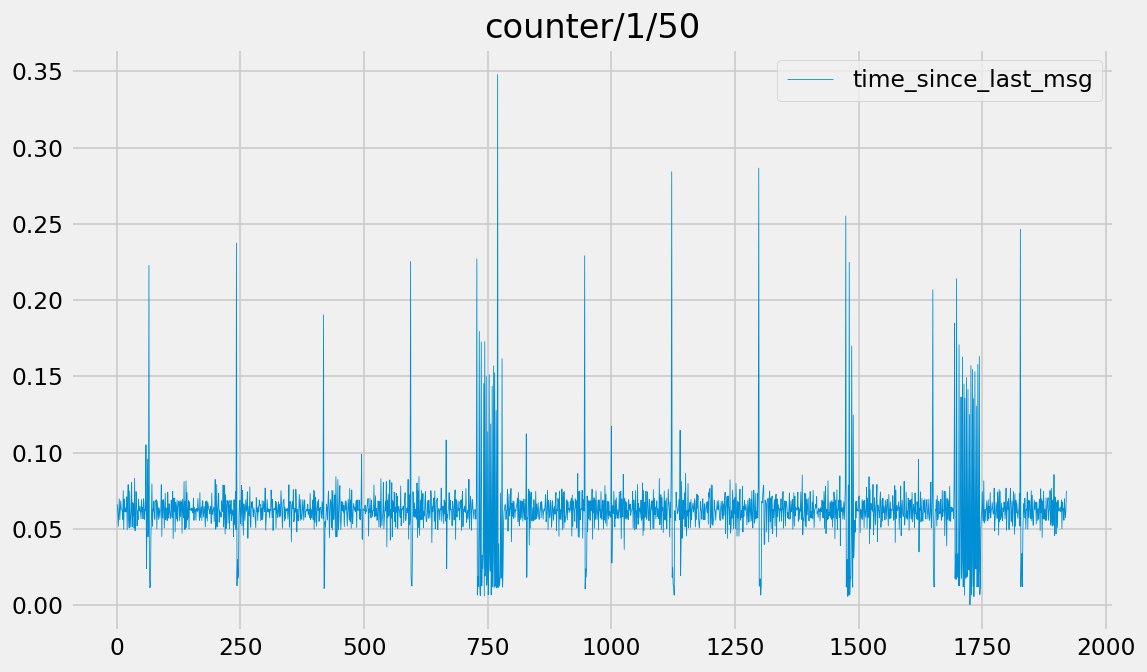

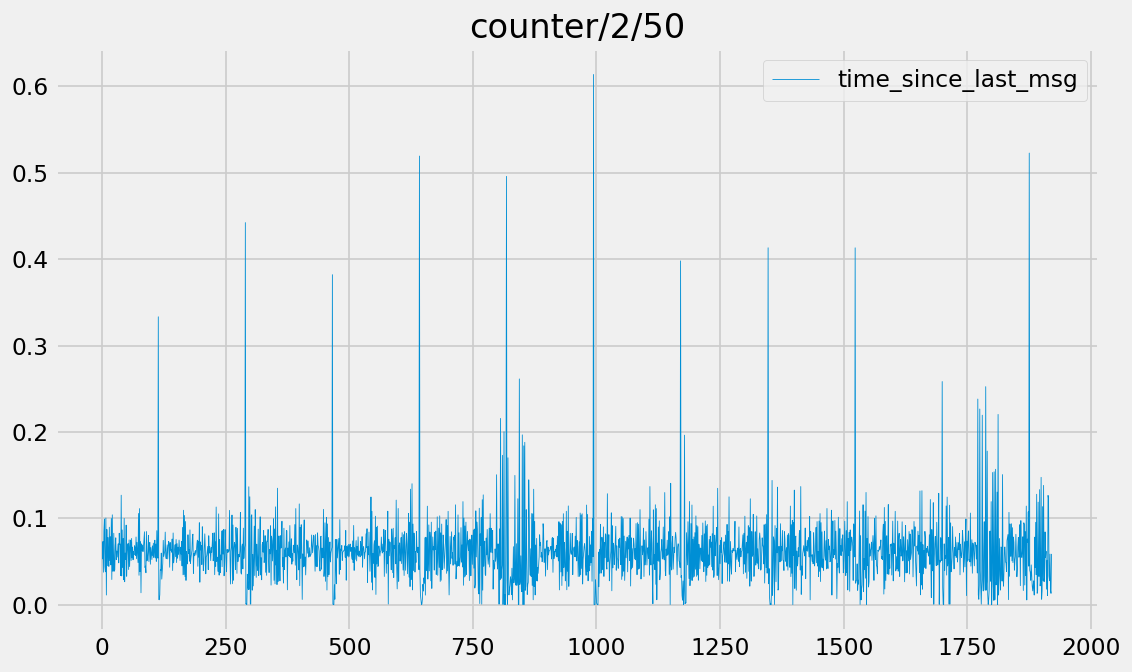

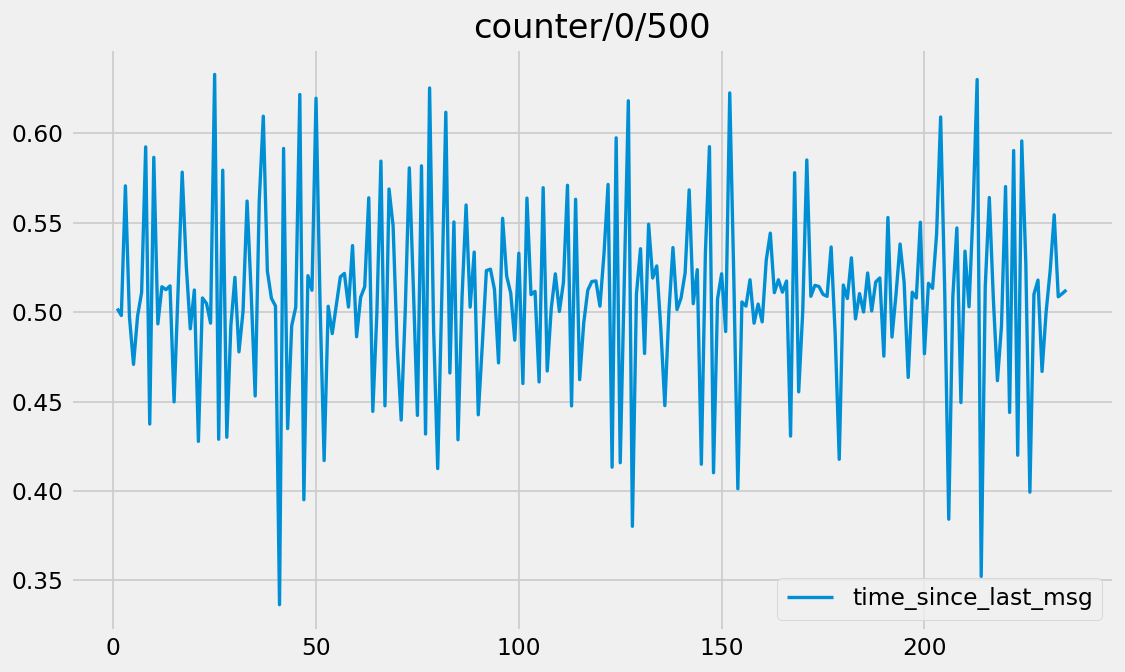

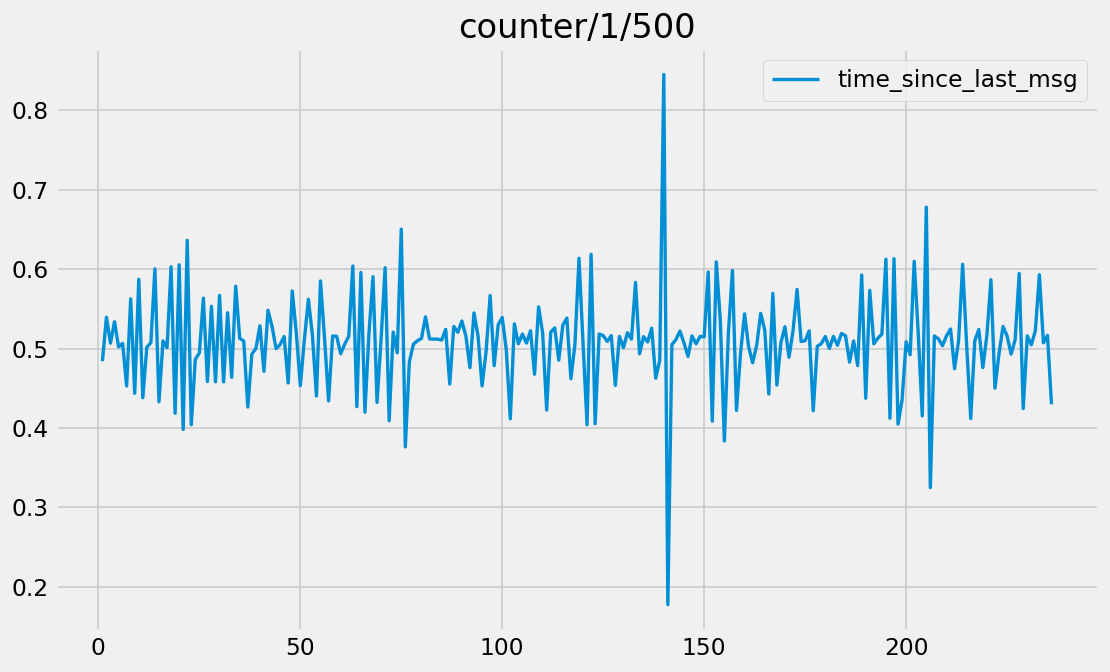

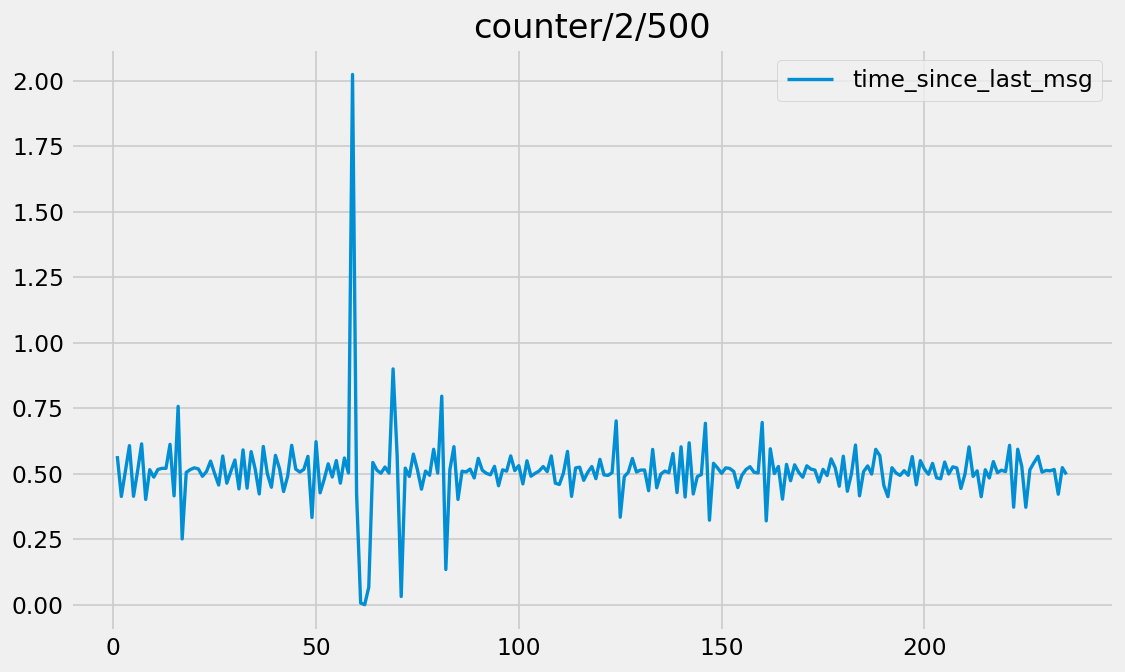

In [22]:
for topic in topics:
    topicdf = data[data['topic']==topic]
    topicdf.reset_index(drop=True, inplace=True)
    width = 0.5 if len(topicdf) >= 500 else 2
    topicdf.plot(kind='line', y='time_since_last_msg', figsize=(10, 6), linewidth=width, title=topic)

$SYS

In [23]:
data = df.copy()

data['time_since_last_msg'] = data[['ts']] - data[['ts']].shift(1)
subdf = data['topic'].str.split('/', expand=True)
subdf.columns = ['_', 'qos', 'delay']
subdf.drop(columns=['_', 'qos'], inplace=True)
data = pd.concat([data, subdf], axis=1)
data = data[['ts', 'time_since_last_msg', 'topic', 'qos', 'delay', 'payload']]
data['delay'] = data['delay'].astype(int)
data.sort_values('ts', inplace=True)
data.reset_index(drop=True, inplace=True)
data

ts  time_since_last_msg          topic  qos  delay  payload
0         2.436267                  NaN  counter/2/500    2    500        0
1         3.003892             0.567625  counter/2/500    2    500        1
2         3.417312             0.413419  counter/2/500    2    500        2
3         3.927627             0.510316  counter/2/500    2    500        3
4         4.535092             0.607464  counter/2/500    2    500        4
...            ...                  ...            ...  ...    ...      ...
74697  2187.967616             0.000232    counter/0/0    0      0    18792
74698  2187.974169             0.006553    counter/0/0    0      0    18793
74699  2187.979699             0.005530    counter/0/0    0      0    18794
74700  2187.996533             0.016834    counter/0/0    0      0    18795
74701  2187.996839             0.000306    counter/0/0    0      0    18796

[74702 rows x 6 columns]

In [24]:
data['actualDelay_expectedDelay_ratio'] = data['time_since_last_msg'] / data['delay']

Text(0.5, 1.0, 'Observed delay / Requested delay')

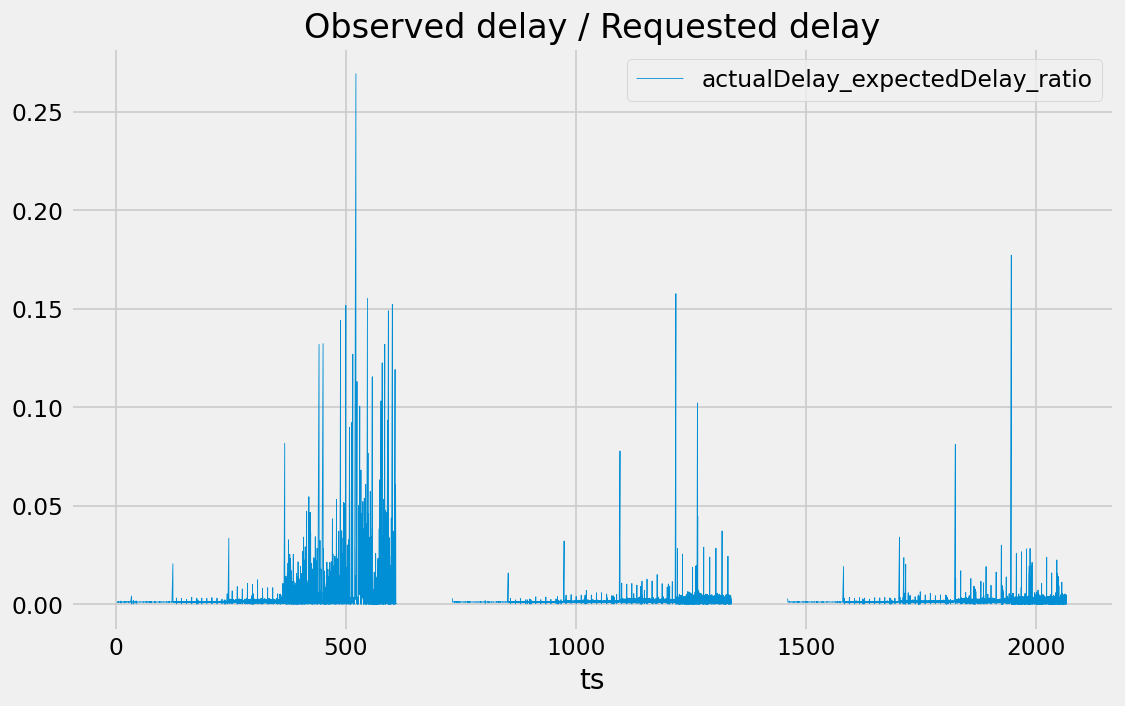

In [25]:
data.plot(kind='line', x='ts', y='actualDelay_expectedDelay_ratio', linewidth=0.5)
plt.title('Observed delay / Requested delay')

Text(0.5, 1.0, 'Time since last message')

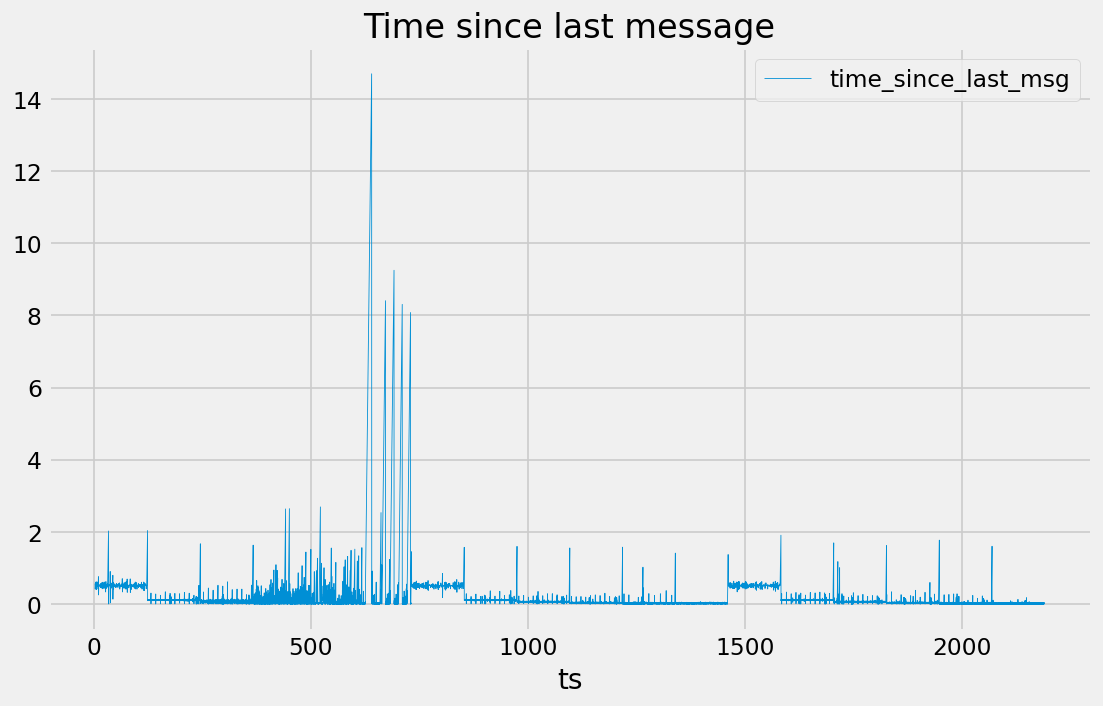

In [26]:
data.plot(kind='line', x='ts', y='time_since_last_msg', linewidth=0.5)
plt.title('Time since last message')

In [27]:
data['ts'] = pd.to_datetime(data['ts'], unit='s')
data.set_index('ts', inplace=True)
data = data.resample('10S').agg({'time_since_last_msg': 'mean', 'payload': 'count'})
data.reset_index(inplace=True)
data.columns = ['ts', 'avg_time_since_last_msg', 'count']

In [28]:
data

ts  avg_time_since_last_msg  count
0   1970-01-01 00:00:00                 0.515139     15
1   1970-01-01 00:00:10                 0.507465     20
2   1970-01-01 00:00:20                 0.505458     20
3   1970-01-01 00:00:30                 0.510402     19
4   1970-01-01 00:00:40                 0.508654     20
..                  ...                      ...    ...
214 1970-01-01 00:35:40                 0.006742   1482
215 1970-01-01 00:35:50                 0.008225   1215
216 1970-01-01 00:36:00                 0.008854   1131
217 1970-01-01 00:36:10                 0.008488   1176
218 1970-01-01 00:36:20                 0.009094    882

[219 rows x 3 columns]

In [29]:
sysdata = sys.copy()
sysdata['ts'] = pd.to_datetime(sysdata['ts'], unit='s')
sysdata.set_index('ts', inplace=True)
sysdata = sysdata.resample('10S').count()
sysdata.reset_index(inplace=True)
sysdata.drop(columns=['topic', 'qos'], inplace=True)
sysdata.rename(columns={'payload': 'sys_count'}, inplace=True)
sysdata

ts  sys_count
0   1970-01-01 00:00:00         44
1   1970-01-01 00:00:10         43
2   1970-01-01 00:00:20         33
3   1970-01-01 00:00:30         36
4   1970-01-01 00:00:40         36
..                  ...        ...
202 1970-01-01 00:33:40         36
203 1970-01-01 00:33:50         37
204 1970-01-01 00:34:00         37
205 1970-01-01 00:34:10         36
206 1970-01-01 00:34:20         37

[207 rows x 2 columns]

In [30]:
merged = pd.merge(data, sysdata, on='ts', how='outer')
merged

ts  avg_time_since_last_msg  count  sys_count
0   1970-01-01 00:00:00                 0.515139     15       44.0
1   1970-01-01 00:00:10                 0.507465     20       43.0
2   1970-01-01 00:00:20                 0.505458     20       33.0
3   1970-01-01 00:00:30                 0.510402     19       36.0
4   1970-01-01 00:00:40                 0.508654     20       36.0
..                  ...                      ...    ...        ...
214 1970-01-01 00:35:40                 0.006742   1482        NaN
215 1970-01-01 00:35:50                 0.008225   1215        NaN
216 1970-01-01 00:36:00                 0.008854   1131        NaN
217 1970-01-01 00:36:10                 0.008488   1176        NaN
218 1970-01-01 00:36:20                 0.009094    882        NaN

[219 rows x 4 columns]

Text(0.5, 1.0, 'Comparison between average delay (10s bins) and volume of $SYS messages')

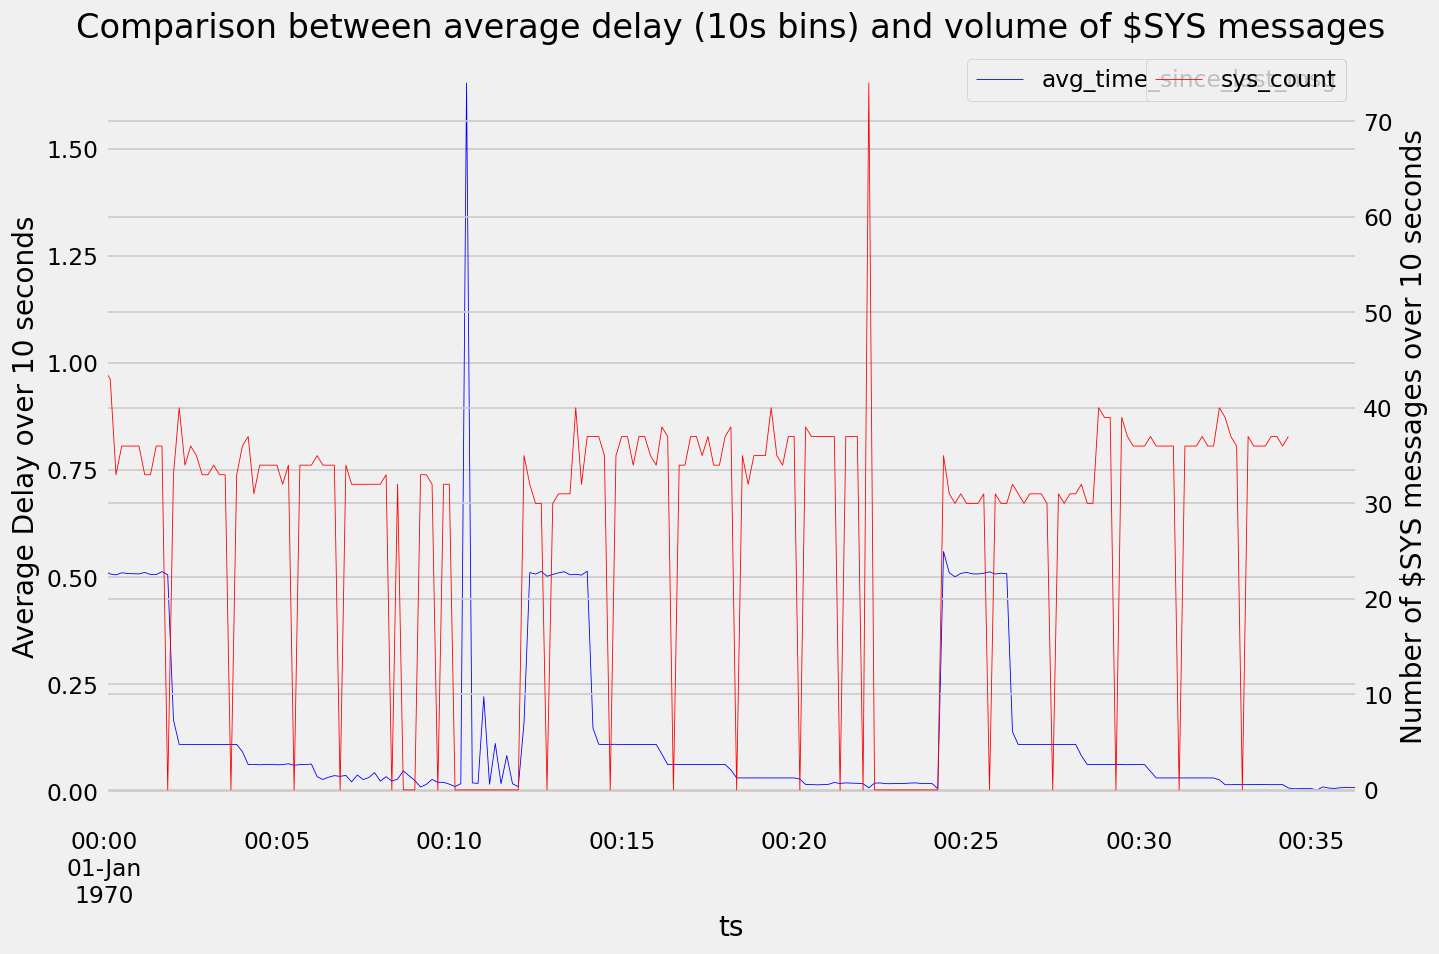

In [31]:
fig, ax = plt.subplots(figsize=(12, 8))
merged.plot(kind='line', x='ts', y='avg_time_since_last_msg', linewidth=0.5, ax=ax, color='blue')
ax.set_ylabel('Average Delay over 10 seconds')

# twin object for two different y-axis on the sample plot
ax2 = ax.twinx()
merged.plot(kind='line', x='ts', y='sys_count', linewidth=0.5, ax=ax2, color='red')
ax2.set_ylabel('Number of $SYS messages over 10 seconds')
plt.title('Comparison between average delay (10s bins) and volume of $SYS messages')

In [32]:
merged[['sys_count', 'avg_time_since_last_msg']].corr()

sys_count  avg_time_since_last_msg
sys_count                 1.000000                 0.038904
avg_time_since_last_msg   0.038904                 1.000000

### Correlation between delay and broker load

`$SYS/broker/load/messages/sent/+` : The moving average of the number of all types of MQTT messages sent by the broker over different time intervals. The final "+" of the hierarchy can be 1min, 5min or 15min. The value returned represents the number of messages send in 1 minute, averaged over 1, 5 or 15 minutes.

In [33]:
sysdata = sys.copy()
sysdata = sysdata[sysdata['topic'].str.startswith('$SYS/broker/load/messages/sent/1min')]
sysdata.head(20)

ts                                topic  qos   payload
8       0.871752  $SYS/broker/load/messages/sent/1min    0  56653.03
65     10.571161  $SYS/broker/load/messages/sent/1min    0  47338.54
127    21.625208  $SYS/broker/load/messages/sent/1min    0  39549.60
181    34.226489  $SYS/broker/load/messages/sent/1min    0  33063.55
239    43.667525  $SYS/broker/load/messages/sent/1min    0  27660.32
297    54.635941  $SYS/broker/load/messages/sent/1min    0  23166.75
354    65.542710  $SYS/broker/load/messages/sent/1min    0  19421.33
412    76.624341  $SYS/broker/load/messages/sent/1min    0  16307.87
467    87.571330  $SYS/broker/load/messages/sent/1min    0  13716.86
521    98.542284  $SYS/broker/load/messages/sent/1min    0  11554.38
579   109.578860  $SYS/broker/load/messages/sent/1min    0   9757.79
637   120.612789  $SYS/broker/load/messages/sent/1min    0   8263.98
746   131.567585  $SYS/broker/load/messages/sent/1min    0   7273.48
883   142.532130  $SYS/broker/load/messages/sent/1min    0   6524.74
1018  153.531825  $SYS/broker/load/messages/sent/1min    0   5905.08
1155  164.590122  $SYS/broker/load/messages/sent/1min    0   5390.13
1290  175.568084  $SYS/broker/load/messages/sent/1min    0   4956.86
1424  186.591748  $SYS/broker/load/messages/sent/1min    0   4601.66
1557  197.529305  $SYS/broker/load/messages/sent/1min    0   4301.39
1692  208.571725  $SYS/broker/load/messages/sent/1min    0   4055.07

In [34]:
sysdata['ts'] = pd.to_datetime(sysdata['ts'], unit='s')
sysdata.set_index('ts', inplace=True)
sysdata['payload'] = sysdata['payload'].astype(float)
sysdata = sysdata.resample('30S').mean()[['payload']]
sysdata.reset_index(inplace=True)
sysdata.rename(columns={'payload': 'moving_avg_msgs_sent_1min'}, inplace=True)
sysdata

ts  moving_avg_msgs_sent_1min
0  1970-01-01 00:00:00               47847.056667
1  1970-01-01 00:00:30               27963.540000
2  1970-01-01 00:01:00               16482.020000
3  1970-01-01 00:01:30               10656.085000
4  1970-01-01 00:02:00                7354.066667
..                 ...                        ...
64 1970-01-01 00:32:00                3883.110000
65 1970-01-01 00:32:30                5027.066667
66 1970-01-01 00:33:00                6045.575000
67 1970-01-01 00:33:30                6671.120000
68 1970-01-01 00:34:00                7115.946667

[69 rows x 2 columns]

In [35]:
data = df.copy()

data['time_since_last_msg'] = data[['ts']] - data[['ts']].shift(1)
subdf = data['topic'].str.split('/', expand=True)
subdf.columns = ['_', 'qos', 'delay']
subdf.drop(columns=['_', 'qos'], inplace=True)
data = pd.concat([data, subdf], axis=1)
data['delay'] = data['delay'].astype(int)
data['actualDelay_expectedDelay_ratio'] = data['time_since_last_msg'] / data['delay']
data = data[['ts', 'time_since_last_msg', 'actualDelay_expectedDelay_ratio', 'topic', 'qos', 'delay', 'payload']]
data.sort_values('ts', inplace=True)
data.reset_index(drop=True, inplace=True)
data['ts'] = pd.to_datetime(data['ts'], unit='s')
data.set_index('ts', inplace=True)
data = data.resample('30S').agg({'time_since_last_msg': 'mean', 'actualDelay_expectedDelay_ratio': 'mean', 'payload': 'count'})
data.reset_index(inplace=True)
data.columns = ['ts', 'avg_time_since_last_msg', 'actualDelay_expectedDelay_ratio', 'count']
data

ts  avg_time_since_last_msg  \
0  1970-01-01 00:00:00                 0.508711   
1  1970-01-01 00:00:30                 0.509049   
2  1970-01-01 00:01:00                 0.508448   
3  1970-01-01 00:01:30                 0.508346   
4  1970-01-01 00:02:00                 0.123668   
..                 ...                      ...   
68 1970-01-01 00:34:00                 0.011713   
69 1970-01-01 00:34:30                 0.006039   
70 1970-01-01 00:35:00                 0.005196   
71 1970-01-01 00:35:30                 0.007491   
72 1970-01-01 00:36:00                 0.008785   

    actualDelay_expectedDelay_ratio  count  
0                          0.001017     55  
1                          0.001018     59  
2                          0.001017     59  
3                          0.001017     59  
4                          0.001172    243  
..                              ...    ...  
68                              inf   2562  
69                              inf   4968  
70                              inf   5771  
71                              inf   4004  
72                              inf   3189  

[73 rows x 4 columns]

In [36]:
merged = pd.merge(data, sysdata, on='ts', how='outer')
merged

ts  avg_time_since_last_msg  \
0  1970-01-01 00:00:00                 0.508711   
1  1970-01-01 00:00:30                 0.509049   
2  1970-01-01 00:01:00                 0.508448   
3  1970-01-01 00:01:30                 0.508346   
4  1970-01-01 00:02:00                 0.123668   
..                 ...                      ...   
68 1970-01-01 00:34:00                 0.011713   
69 1970-01-01 00:34:30                 0.006039   
70 1970-01-01 00:35:00                 0.005196   
71 1970-01-01 00:35:30                 0.007491   
72 1970-01-01 00:36:00                 0.008785   

    actualDelay_expectedDelay_ratio  count  moving_avg_msgs_sent_1min  
0                          0.001017     55               47847.056667  
1                          0.001018     59               27963.540000  
2                          0.001017     59               16482.020000  
3                          0.001017     59               10656.085000  
4                          0.001172    243                7354.066667  
..                              ...    ...                        ...  
68                              inf   2562                7115.946667  
69                              inf   4968                        NaN  
70                              inf   5771                        NaN  
71                              inf   4004                        NaN  
72                              inf   3189                        NaN  

[73 rows x 5 columns]

In [37]:
merged

ts  avg_time_since_last_msg  \
0  1970-01-01 00:00:00                 0.508711   
1  1970-01-01 00:00:30                 0.509049   
2  1970-01-01 00:01:00                 0.508448   
3  1970-01-01 00:01:30                 0.508346   
4  1970-01-01 00:02:00                 0.123668   
..                 ...                      ...   
68 1970-01-01 00:34:00                 0.011713   
69 1970-01-01 00:34:30                 0.006039   
70 1970-01-01 00:35:00                 0.005196   
71 1970-01-01 00:35:30                 0.007491   
72 1970-01-01 00:36:00                 0.008785   

    actualDelay_expectedDelay_ratio  count  moving_avg_msgs_sent_1min  
0                          0.001017     55               47847.056667  
1                          0.001018     59               27963.540000  
2                          0.001017     59               16482.020000  
3                          0.001017     59               10656.085000  
4                          0.001172    243                7354.066667  
..                              ...    ...                        ...  
68                              inf   2562                7115.946667  
69                              inf   4968                        NaN  
70                              inf   5771                        NaN  
71                              inf   4004                        NaN  
72                              inf   3189                        NaN  

[73 rows x 5 columns]

Text(0.5, 1.0, 'Comparison between average delay (30s bins) and Number of messages sent in the last 1 minute')

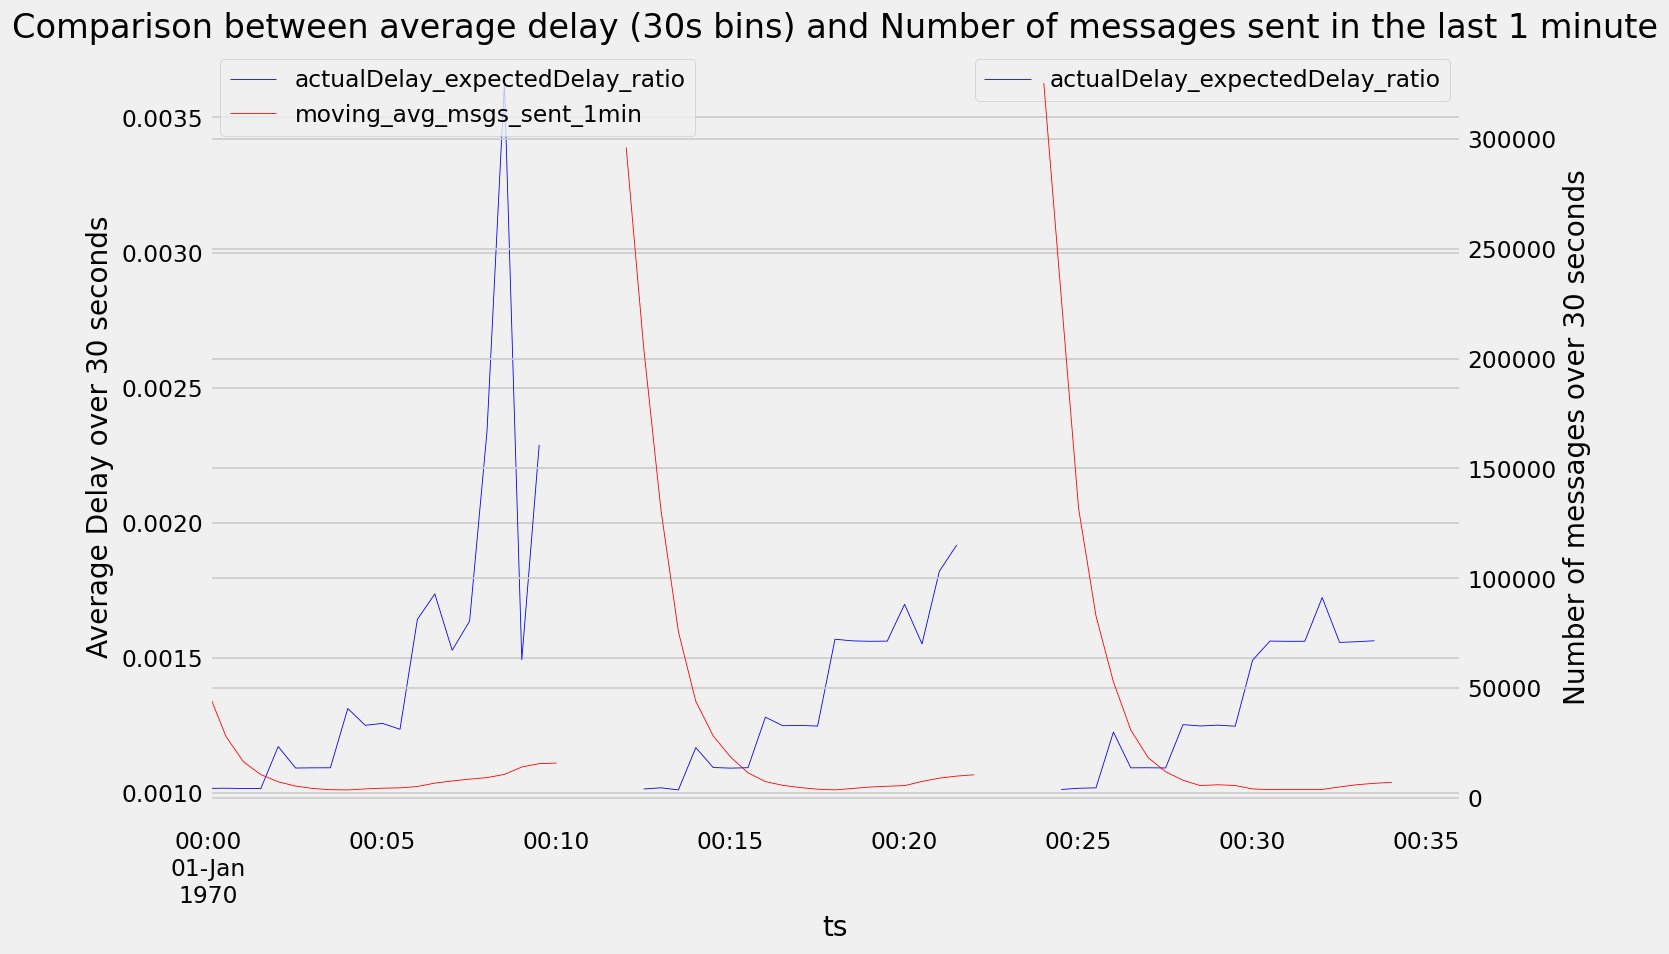

In [38]:
fig, ax = plt.subplots(figsize=(12, 8))
merged.plot(kind='line', x='ts', y='actualDelay_expectedDelay_ratio', linewidth=0.5, ax=ax, color='blue')
ax.set_ylabel('Average Delay over 30 seconds')

# twin object for two different y-axis on the sample plot
ax2 = ax.twinx()
merged.plot(kind='line', x='ts', y='moving_avg_msgs_sent_1min', linewidth=0.5, ax=ax2, color='red')
ax2.set_ylabel('Number of messages over 30 seconds')

# ask matplotlib for the plotted objects and their labels
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc=0)

plt.title('Comparison between average delay (30s bins) and Number of messages sent in the last 1 minute')

In [39]:
print('order of request sent to broker')
list(df['topic'].unique())

order of request sent to broker


['counter/2/500',
 'counter/2/100',
 'counter/2/50',
 'counter/2/20',
 'counter/2/10',
 'counter/2/0',
 'counter/1/500',
 'counter/1/100',
 'counter/1/50',
 'counter/1/20',
 'counter/1/10',
 'counter/1/0',
 'counter/0/500',
 'counter/0/100',
 'counter/0/50',
 'counter/0/20',
 'counter/0/10',
 'counter/0/0']